# Recurrent Neural Network

In [1]:
import numpy as np
import logging

import matplotlib.pyplot as plt
import pandas as pd
import sys
import json
import math

import tensorflow as tf
import joblib as jb

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from core.util.timer import Timer
from core.model import Model

Using TensorFlow backend.


In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
dataset = jb.load('data/cleaned/unnormalized_Wanshouxigong.joblib')

In [86]:
## Preparing Data
def prepare(dataset, feature_col="SO2"):
    dataset = dataset[[feature_col]]
    series = dataset[feature_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values = scaler.fit_transform(values)
    X = values[:-1]
    y = values[1:]
    
    return X, y

def split(X, y):
    train_index = (0, 21000)
    validation_index = (21000, 28000)
    test_index = (28000, len(X) - 1)
    
    X_train, X_val, X_test = X[:train_index[1]], X[validation_index[0]:validation_index[1]], X[test_index[0]:]
    y_train, y_val, y_test = y[:train_index[1]], y[validation_index[0]:validation_index[1]], y[test_index[0]:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def reshape(sequences):
    keras.backend.clear_session()
    
    for idx, sequence in enumerate(sequences):
        sequences[idx] = sequence.reshape(sequence.shape[0], sequence.shape[1], 1)

    return sequences

def get_scaler(dataset, feature_col="SO2"):
    dataset = dataset[[feature_col]]
    series = dataset[feature_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values = scaler.fit_transform(values)
    return scaler

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
            
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')

    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    
def load_model_config(cityName, pollutant):
    configs = json.load(open('core/config.json', 'r'))
    return configs['data'][cityName][pollutant]


## Forecasting O3 with SimpleRNN

In [5]:
X, y = prepare(dataset, "O3")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [6]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [7]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.14 seconds.


In [8]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 61us/step - loss: 0.0211
Epoch 2/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0099
Epoch 3/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0099
Epoch 4/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0098
Epoch 5/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0098
Epoch 6/30
21000/21000 [==============================] - 1s 48us/step - loss: 0.0098
Epoch 7/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0097
Epoch 8/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0097
Epoch 9/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0097
Epoch 10/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0097
Epoch 11/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0097
Epoch 12/30
21000/21000 [===========================

In [10]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))

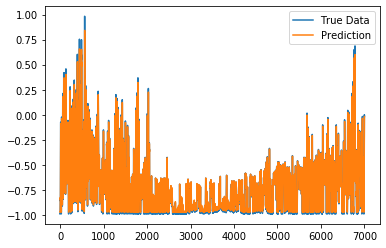

In [11]:
plot_results(predicted, y_val)

In [15]:
model.save("data/model/simple_rnn_o3.rnn")

## Forecasting SO2 with SimpleRNN

In [16]:
X, y = prepare(dataset, "SO2")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [18]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [17]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.08 seconds.


In [19]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 60us/step - loss: 0.0029
Epoch 2/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0019
Epoch 3/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0019
Epoch 4/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0019
Epoch 5/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0019
Epoch 6/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0019
Epoch 7/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0019
Epoch 8/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0019
Epoch 9/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0019
Epoch 10/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0019
Epoch 11/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0019
Epoch 12/30
21000/21000 [===========================

In [20]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))

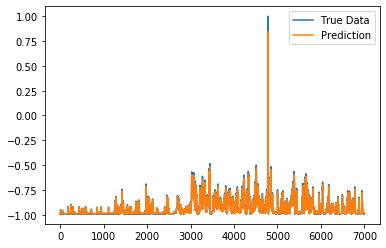

In [21]:
plot_results(predicted, y_val)

In [22]:
model.save("data/model/simple_rnn_so2.rnn")

## Forecasting CO with SimpleRNN

In [43]:
X, y = prepare(dataset, "CO")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [44]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [45]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.07 seconds.


In [46]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 61us/step - loss: 0.0813
Epoch 2/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0064
Epoch 3/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0060
Epoch 4/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0060
Epoch 5/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0060
Epoch 6/30
21000/21000 [==============================] - 1s 55us/step - loss: 0.0060
Epoch 7/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0060
Epoch 8/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0060
Epoch 9/30
21000/21000 [==============================] - 1s 48us/step - loss: 0.0060
Epoch 10/30
21000/21000 [==============================] - 1s 48us/step - loss: 0.0060
Epoch 11/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0060
Epoch 12/30
21000/21000 [===========================

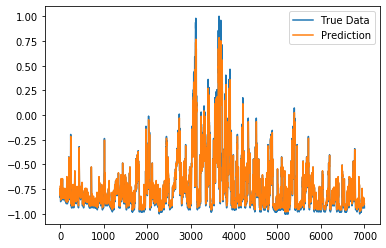

In [47]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))
plot_results(predicted, y_val)

In [48]:
model.save("data/model/simple_rnn_co.rnn")

## Forecasting TEMP with SimpleRNN

In [49]:
X, y = prepare(dataset, "TEMP")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [50]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [51]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.07 seconds.


In [52]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 66us/step - loss: 0.0073
Epoch 2/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0024
Epoch 3/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0023
Epoch 4/30
21000/21000 [==============================] - 1s 55us/step - loss: 0.0023
Epoch 5/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0023
Epoch 6/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0023
Epoch 7/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0023
Epoch 8/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0023
Epoch 9/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0023
Epoch 10/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0023
Epoch 11/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0023
Epoch 12/30
21000/21000 [===========================

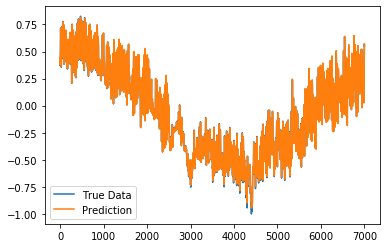

In [53]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))
plot_results(predicted, y_val)

In [54]:
model.save("data/model/simple_rnn_temp.rnn")

## Forecasting PRES with SimpleRNN

In [59]:
X, y = prepare(dataset, "PRES")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [60]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [61]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.21 seconds.


In [62]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 59us/step - loss: 0.0016
Epoch 2/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0015
Epoch 3/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0015
Epoch 4/30
21000/21000 [==============================] - 1s 54us/step - loss: 0.0015
Epoch 5/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0015
Epoch 6/30
21000/21000 [==============================] - 1s 48us/step - loss: 0.0015
Epoch 7/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0015
Epoch 8/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0015
Epoch 9/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0015
Epoch 10/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0015
Epoch 11/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0015
Epoch 12/30
21000/21000 [===========================

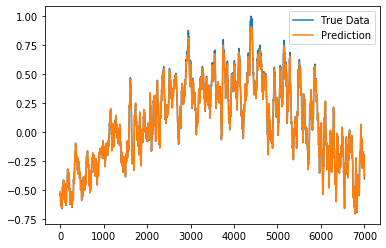

In [63]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))
plot_results(predicted, y_val)

In [64]:
model.save("data/model/simple_rnn_pres.rnn")

## Forecasting DEWP with SimpleRNN

In [66]:
X, y = prepare(dataset, "DEWP")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [67]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [68]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.08 seconds.


In [69]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 61us/step - loss: 0.0352
Epoch 2/30
21000/21000 [==============================] - 1s 55us/step - loss: 0.0019
Epoch 3/30
21000/21000 [==============================] - 1s 55us/step - loss: 0.0019
Epoch 4/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0019
Epoch 5/30
21000/21000 [==============================] - 1s 48us/step - loss: 0.0019
Epoch 6/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0019
Epoch 7/30
21000/21000 [==============================] - 1s 54us/step - loss: 0.0018
Epoch 8/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0018
Epoch 9/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0018
Epoch 10/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0018
Epoch 11/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0018
Epoch 12/30
21000/21000 [===========================

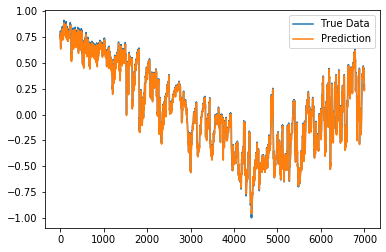

In [70]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))
plot_results(predicted, y_val)

In [71]:
model.save("data/model/simple_rnn_dewp.rnn")

## Forecasting WSPM with SimpleRNN

In [72]:
X, y = prepare(dataset, "WSPM")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [73]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [74]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.08 seconds.


In [75]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 66us/step - loss: 0.0188
Epoch 2/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0156
Epoch 3/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0157
Epoch 4/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0156
Epoch 5/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0156
Epoch 6/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0156
Epoch 7/30
21000/21000 [==============================] - 1s 54us/step - loss: 0.0156
Epoch 8/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0157
Epoch 9/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0157
Epoch 10/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0156
Epoch 11/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0156
Epoch 12/30
21000/21000 [===========================

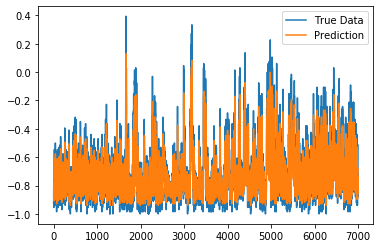

In [76]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))
plot_results(predicted, y_val)

In [77]:
model.save("data/model/simple_rnn_wspm.rnn")

In [79]:
jb.dump(X_test, 'data/X_test.joblib')
jb.dump(y_test, 'data/y_test.joblib')

['data/y_test.joblib']

## Baseline Forecasting PM2.5 with SimpleRNN

In [80]:
X, y = prepare(dataset, "PM2.5")
keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)
toReshape = [X_train, X_val, X_test]
reshaped = reshape(toReshape)
X_train, X_val, X_test = reshaped[0], reshaped[1], reshaped[2]

In [81]:
model_configs = load_model_config("Wanshouxigong", "SO2")

In [82]:
model = Sequential()
with Timer(logger, "Building Model"):
    for layer in model_configs['model']['layers']:
        units = layer['units'] if 'units' in layer else None
        dropout_rate = layer['rate'] if 'rate' in layer else None
        activation = layer['activation'] if 'activation' in layer else None
        return_seq = layer['return_seq'] if 'return_seq' in layer else None
        input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
        input_dim = layer['input_dim'] if 'input_dim' in layer else None

  
        if layer['type'] == 'dense':
            model.add(Dense(units, activation=activation))
        if layer['type'] == 'simple':
            model.add(SimpleRNN(units, input_shape=(input_timesteps, input_dim)))
        if layer['type'] == 'lstm':
            model.add(LSTM(units, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
        if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

    model.compile(loss=model_configs['model']['loss'], optimizer=model_configs['model']['optimizer'])

INFO:__main__:Started Building Model
INFO:__main__:Finished Building Model in 0.17 seconds.


In [83]:
nb_epoch = 30
batch_size = 16
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/30
21000/21000 [==============================] - 1s 70us/step - loss: 0.0048: 0s - loss: 0
Epoch 2/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0020
Epoch 3/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0020
Epoch 4/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0020
Epoch 5/30
21000/21000 [==============================] - 1s 52us/step - loss: 0.0020
Epoch 6/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0020
Epoch 7/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0020
Epoch 8/30
21000/21000 [==============================] - 1s 49us/step - loss: 0.0020
Epoch 9/30
21000/21000 [==============================] - 1s 53us/step - loss: 0.0020
Epoch 10/30
21000/21000 [==============================] - 1s 51us/step - loss: 0.0020
Epoch 11/30
21000/21000 [==============================] - 1s 50us/step - loss: 0.0020
Epoch 12/30
21000/21000 [=============

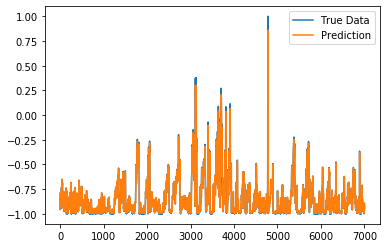

In [84]:
predicted = model.predict(X_val)
predicted = np.reshape(predicted, (predicted.size,))
plot_results(predicted, y_val)

In [88]:
scaler_pm25 = get_scaler(dataset, feature_col="PM2.5")

In [97]:
predicted = predicted.reshape(7000, 1)

In [102]:
rescaled = scaler_pm25.inverse_transform(predicted)
rescaled_y_val = scaler_pm25.inverse_transform(y_val)

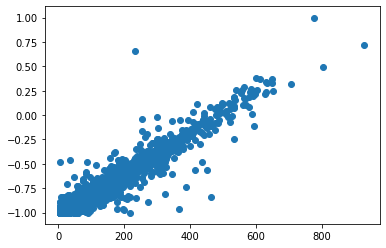

In [103]:
plt.scatter(rescaled, y_val)

In [104]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

def validate_prediction(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return "mse = {mse} & mae = {mae} & rmse = {rmse}".format(mse=mse, mae=mae, rmse=sqrt(mse))

In [106]:
validate_prediction(rescaled, rescaled_y_val)

'mse = 554.9825284677587 & mae = 12.06801136897824 & rmse = 23.55806716324068'

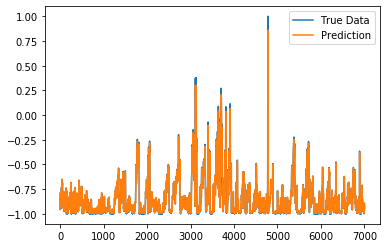

In [107]:
predicted = np.reshape(predicted, (predicted.size,))
plot_results(predicted, y_val)